In [ ]:
import os
from keras.utils.np_utils import to_categorical
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random 
import numpy as np

In [ ]:
# !unzip "/content/drive/MyDrive/cleaned_data.zip" -d "/content/drive/MyDrive/Ultrasound Data/New Ultrasound Data"

In [ ]:
DATASET = "/content/drive/MyDrive/Ultrasound Data/New Ultrasound Data/content/data"

In [ ]:
# paths = os.listdir(DATASET)[0:3]
# paths

['train', '.ipynb_checkpoints', 'test']

In [ ]:
train_path = "/content/drive/MyDrive/Ultrasound Data/New Ultrasound Data/content/data/train"
test_path = "/content/drive/MyDrive/Ultrasound Data/New Ultrasound Data/content/data/test"
val_path = "/content/drive/MyDrive/Ultrasound Data/New Ultrasound Data/content/data/val"

In [ ]:
for subdirs in os.listdir(train_path):
  print(subdirs)

infected
notinfected


In [ ]:
LABELS = ['infected', 'notinfected']
IMG_SIZE = 224

In [ ]:
train_images = []
test_images = []
val_images = []

for label in LABELS:
  for img in glob.iglob(os.path.join(DATASET, "train", label, "*")):
    train_images.append(img)
  for img in glob.iglob(os.path.join(DATASET, "test", label, "*")):
    test_images.append(img)
  for img in glob.iglob(os.path.join(DATASET, "val", label, "*")):
    val_images.append(img)

print("Train samples: ", len(train_images))
print("Validation samples: ", len(val_images))
print("Test samples: ", len(test_images))



Train samples:  1924
Validation samples:  1536
Test samples:  386


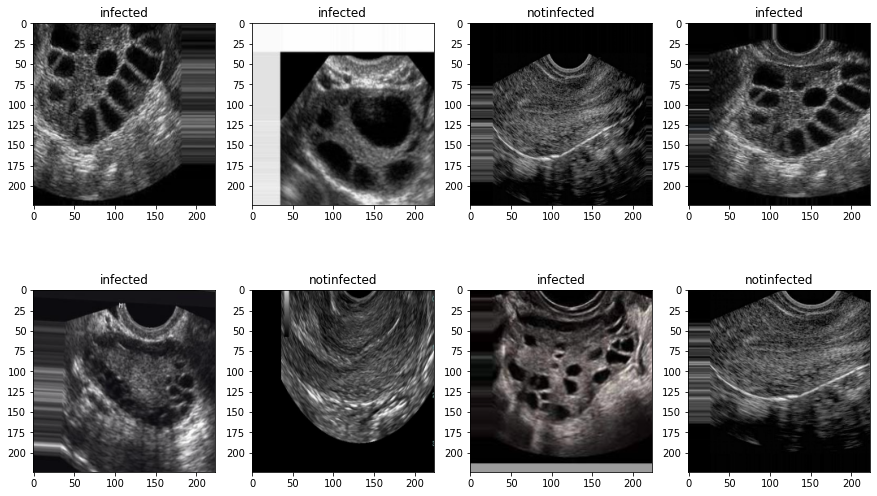

In [ ]:
import random
images = []
labels = []
for image in random.choices(train_images, k = 8):
  images.append(cv2.resize(cv2.imread(image),(224, 224)))
  labels.append(os.path.dirname(image).split('/')[-1]) 
  # get the dirname split with '/' and take the last value

# print(labels)

fig=plt.figure(figsize=(15, 9))
rows, cols = 2, 4
for j in range(0, cols*rows):
  fig.add_subplot(rows, cols, j+1)
  plt.imshow(images[j])
  plt.title(labels[j])
plt.show()

In [ ]:
# os.path.dirname('/content/drive/MyDrive/Ultrasound Data/New Ultrasound Data/content/data/train/infected/img1.jpg').split('/')[-1]

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
training_data = []
def create_training_data():
    for category in LABELS:
        path = os.path.join(train_path, category)
        class_num = LABELS.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,(IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                print(e)
create_training_data()

In [ ]:
random.shuffle(training_data)

In [ ]:
X = []
Y = []

for categories, label in training_data:
    X.append(categories)
    Y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
X.shape

(1924, 224, 224, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = (Y))

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, stratify = (Y_train))

In [ ]:
X_train = np.asarray(X_train, dtype=np.float32)
Y_train = np.asarray(Y_train, dtype=np.float32)

X_test = np.asarray(X_test, dtype=np.float32)
Y_test = np.asarray(Y_test, dtype=np.float32)

X_val = np.asarray(X_val, dtype=np.float32)
Y_val = np.asarray(Y_val, dtype=np.float32)

In [ ]:
unique, counts = np.unique(Y_train, return_counts = True)
print("The train categories distribution is:\n", dict(zip(unique, counts)))
unique, counts = np.unique(Y_test, return_counts = True)
print("The test categories distribution is:\n", dict(zip(unique, counts)))
unique, counts = np.unique(Y_val, return_counts = True)
print("The val categories distribution is:\n", dict(zip(unique, counts)))

The train categories distribution is:
 {0.0: 500, 1.0: 731}
The test categories distribution is:
 {0.0: 156, 1.0: 229}
The val categories distribution is:
 {0.0: 125, 1.0: 183}


In [ ]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
Y_test = to_categorical(Y_test)

In [ ]:
#Dimension of the dataset
print("Train set:\n",(X_train.shape,Y_train.shape))
print("Validation set:\n",(X_val.shape,Y_val.shape))
print("Test set:\n",(X_test.shape,Y_test.shape))

Train set:
 ((1231, 224, 224, 3), (1231, 2))
Validation set:
 ((308, 224, 224, 3), (308, 2))
Test set:
 ((385, 224, 224, 3), (385, 2))


In [ ]:
train_generator = ImageDataGenerator(rotation_range=5,
                                     horizontal_flip=True,
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     shear_range=0.5,
                                     zoom_range=0.5,
                                    fill_mode='nearest'
                                    )

In [ ]:
train_generator.fit(X_train)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
IMG_SHAPE = X_train[0].shape
base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = IMG_SHAPE)
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model= Sequential()
model.add(Rescaling(1./255,input_shape = IMG_SHAPE))
model.add(base_model)
model.add(Flatten())
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.add(Dense(32,activation=('relu')))
model.add(Dropout(.5))

# final layer
model.add(Dense(2,activation=('softmax')))

# Sanity check
print(f"\nModel input shape:\n{model.input_shape}\nModel output shape:\n"\
f"{model.output_shape}\n\n\nModel summary:") 
model.summary()


Model input shape:
(None, 224, 224, 3)
Model output shape:
(None, 2)


Model summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 32)                802848    
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                 

In [ ]:
#Initializing the hyperparameters
batch_size= 16
initial_epochs=15
learn_rate=0.0001
adam = Adam(learning_rate=learn_rate)

model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator.flow(X_train, Y_train, batch_size= batch_size),
                    epochs=initial_epochs,
                    validation_data=(X_val,Y_val),
                    steps_per_epoch=10,
                    validation_steps=len(X_val),
                    verbose = 1)

Epoch 1/15
10/10 [==============================] - 7s 573ms/step - loss: 0.6989 - accuracy: 0.5875 - val_loss: 0.6240 - val_accuracy: 0.6006
Epoch 2/15
10/10 [==============================] - 4s 473ms/step - loss: 0.6794 - accuracy: 0.5912 - val_loss: 0.6011 - val_accuracy: 0.9123
Epoch 3/15
10/10 [==============================] - 8s 810ms/step - loss: 0.6104 - accuracy: 0.7170 - val_loss: 0.5222 - val_accuracy: 0.7890
Epoch 4/15
10/10 [==============================] - 7s 755ms/step - loss: 0.5987 - accuracy: 0.7000 - val_loss: 0.4715 - val_accuracy: 0.8019
Epoch 5/15
10/10 [==============================] - 5s 482ms/step - loss: 0.6355 - accuracy: 0.6938 - val_loss: 0.4708 - val_accuracy: 0.9773
Epoch 6/15
10/10 [==============================] - 7s 763ms/step - loss: 0.5307 - accuracy: 0.8062 - val_loss: 0.4278 - val_accuracy: 0.8571
Epoch 7/15
10/10 [==============================] - 7s 748ms/step - loss: 0.5329 - accuracy: 0.7750 - val_loss: 0.3721 - val_accuracy: 0.9383
Epoch 

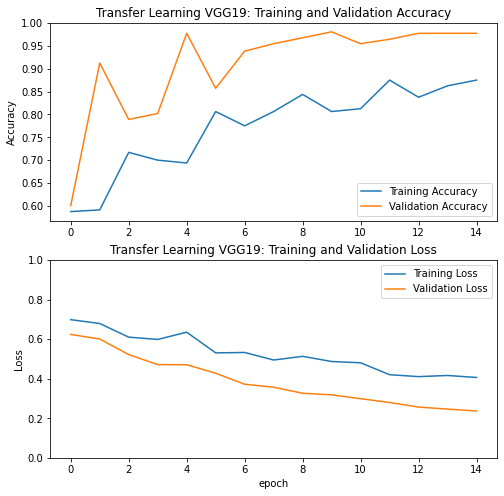

25/25 [==============================] - 2s 64ms/step - loss: 0.2515 - accuracy: 0.9766
Model accuracy on test set: 97.7%


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Transfer Learning VGG19: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Transfer Learning VGG19: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

_ , accuracy = model.evaluate(x=X_test,y=Y_test,batch_size= batch_size,verbose=1)
print(f'Model accuracy on test set: {round(accuracy,3)*100}%')

In [ ]:
epochs_try_2 = 30

In [ ]:
history_1 = model.fit(train_generator.flow(X_train, Y_train, batch_size= batch_size),
                    epochs=epochs_try_2,
                    validation_data=(X_val,Y_val),
                    steps_per_epoch=10,
                    validation_steps=len(X_val),
                    verbose = 1)

Epoch 1/30
10/10 [==============================] - 5s 512ms/step - loss: 0.4409 - accuracy: 0.8188 - val_loss: 0.2250 - val_accuracy: 0.9773
Epoch 2/30
10/10 [==============================] - 5s 574ms/step - loss: 0.4157 - accuracy: 0.8875 - val_loss: 0.2108 - val_accuracy: 0.9805
Epoch 3/30
10/10 [==============================] - 4s 470ms/step - loss: 0.4187 - accuracy: 0.8813 - val_loss: 0.2083 - val_accuracy: 0.9805
Epoch 4/30
10/10 [==============================] - 5s 478ms/step - loss: 0.3859 - accuracy: 0.9062 - val_loss: 0.1991 - val_accuracy: 0.9740
Epoch 5/30
10/10 [==============================] - 7s 786ms/step - loss: 0.3868 - accuracy: 0.8813 - val_loss: 0.1849 - val_accuracy: 0.9805
Epoch 6/30
10/10 [==============================] - 5s 559ms/step - loss: 0.3678 - accuracy: 0.8938 - val_loss: 0.1733 - val_accuracy: 0.9773
Epoch 7/30
10/10 [==============================] - 7s 748ms/step - loss: 0.3965 - accuracy: 0.8687 - val_loss: 0.1648 - val_accuracy: 0.9968
Epoch 

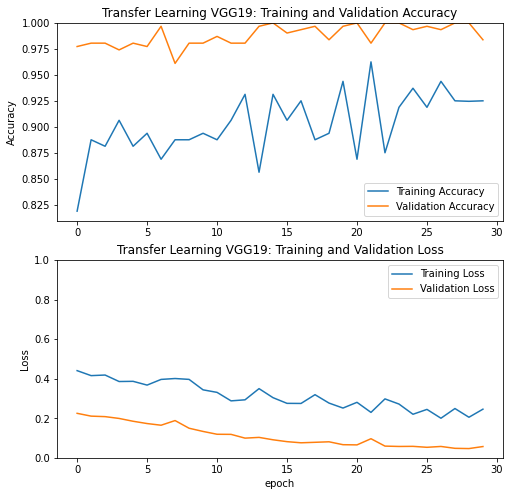

25/25 [==============================] - 2s 65ms/step - loss: 0.0651 - accuracy: 0.9974
Model accuracy on test set: 99.7%


In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Transfer Learning VGG19: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Transfer Learning VGG19: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

_ , accuracy = model.evaluate(x=X_test,y=Y_test,batch_size= batch_size,verbose=1)
print(f'Model accuracy on test set: {round(accuracy,3)*100}%')

In [ ]:
model_try_2 = Sequential()
model_try_2.add(Rescaling(1./255,input_shape = IMG_SHAPE))
model_try_2.add(base_model)
model_try_2.add(Flatten())
model_try_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model_try_2.add(Dense(32,activation=('relu')))
model_try_2.add(Dropout(.5))

# final layer
model_try_2.add(Dense(2,activation=('softmax')))

# Sanity check
print(f"\nModel input shape:\n{model.input_shape}\nModel output shape:\n"\
f"{model.output_shape}\n\n\nModel summary:") 
model_try_2.summary()


Model input shape:
(None, 224, 224, 3)
Model output shape:
(None, 32)


Model summary:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_13 (Dense)            (None, 32)                802848    
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 2)                 66        
                                

In [ ]:
# Try for early stopping
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Stops training when 90% accuracy is reached
    '''
    # Get the current accuracy and check if it is above 95%
    if(logs.get('accuracy') > 0.90):

      # Stop training if condition is met
      print("\nThreshold reached. Stopping training...")
      self.model.stop_training = True

# Let's instantiate our ES class
early_stopping = EarlyStopping()

In [ ]:
# model_try_2.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history_2 = model_try_2.fit(train_generator.flow(X_train, Y_train, batch_size= batch_size),
                    epochs=epochs_try_2,
                    validation_data=(X_val,Y_val),
                    steps_per_epoch=10,
                    validation_steps=len(X_val),
                    verbose = 1,
                    callbacks=[early_stopping]
                    )

Epoch 1/30
10/10 [==============================] - 77s 532ms/step - loss: 0.7265 - accuracy: 0.5750 - val_loss: 0.6006 - val_accuracy: 0.6623
Epoch 2/30
10/10 [==============================] - 8s 831ms/step - loss: 0.6522 - accuracy: 0.6125 - val_loss: 0.5484 - val_accuracy: 0.8636
Epoch 3/30
10/10 [==============================] - 7s 749ms/step - loss: 0.6244 - accuracy: 0.6375 - val_loss: 0.4720 - val_accuracy: 0.9188
Epoch 4/30
10/10 [==============================] - 7s 753ms/step - loss: 0.5621 - accuracy: 0.7296 - val_loss: 0.3923 - val_accuracy: 0.9351
Epoch 5/30
10/10 [==============================] - 8s 836ms/step - loss: 0.5142 - accuracy: 0.7750 - val_loss: 0.3506 - val_accuracy: 0.9481
Epoch 6/30
10/10 [==============================] - 5s 479ms/step - loss: 0.5025 - accuracy: 0.8375 - val_loss: 0.2964 - val_accuracy: 0.9870
Epoch 7/30
10/10 [==============================] - 6s 594ms/step - loss: 0.4553 - accuracy: 0.8188 - val_loss: 0.2644 - val_accuracy: 0.9805
Epoch

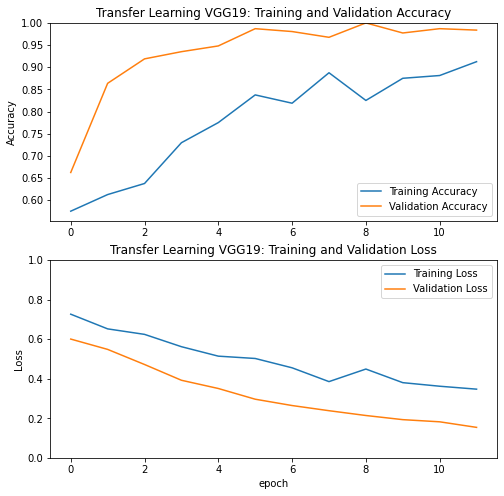

49/49 [==============================] - 3s 48ms/step - loss: 0.1711 - accuracy: 0.9870
Model accuracy on test set: 98.7%


In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Transfer Learning VGG19: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Transfer Learning VGG19: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

_ , accuracy = model_try_2.evaluate(x=X_test,y=Y_test,batch_size= batch_size,verbose=1)
print(f'Model accuracy on test set: {round(accuracy,3)*100}%')

In [ ]:
model_final= Sequential()
model_final.add(Rescaling(1./255,input_shape = IMG_SHAPE))
model_final.add(base_model)
model_final.add(Flatten())
model_final.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model_final.add(Dense(16,activation=('relu')))
model_final.add(Dropout(.3))

# final layer
model_final.add(Dense(2,activation=('softmax')))

# Sanity check
print(f"\nModel input shape:\n{model.input_shape}\nModel output shape:\n"\
f"{model_final.output_shape}\n\n\nModel summary:") 
model_final.summary()


Model input shape:
(None, 224, 224, 3)
Model output shape:
(None, 2)


Model summary:
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_23 (Dense)            (None, 16)                401424    
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_24 (Dense)            (None, 2)                 34        
                                 

In [ ]:
#Initializing the hyperparameters
batch_size= 8
initial_epochs=15
learn_rate=0.0001
adam = Adam(learning_rate=learn_rate)

model_final.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
class EarlyStopping_final(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Stops training when 95% accuracy is reached
    '''
    # Get the current accuracy and check if it is above 95%
    if(logs.get('accuracy') > 0.95):

      # Stop training if condition is met
      print("\nThreshold reached. Stopping training...")
      self.model.stop_training = True

# Let's instantiate our ES class
early_stopping = EarlyStopping()

In [ ]:
history_final = model_final.fit(train_generator.flow(X_train, Y_train, batch_size= batch_size),
                    epochs=epochs_try_2,
                    validation_data=(X_val,Y_val),
                    steps_per_epoch=10,
                    validation_steps=len(X_val),
                    verbose = 1,
                    callbacks=[early_stopping]
                    )

Epoch 1/30
10/10 [==============================] - 5s 449ms/step - loss: 0.7761 - accuracy: 0.5000 - val_loss: 0.6546 - val_accuracy: 0.5942
Epoch 2/30
10/10 [==============================] - 4s 398ms/step - loss: 0.6740 - accuracy: 0.6375 - val_loss: 0.6241 - val_accuracy: 0.6104
Epoch 3/30
10/10 [==============================] - 4s 386ms/step - loss: 0.6673 - accuracy: 0.5875 - val_loss: 0.6211 - val_accuracy: 0.6104
Epoch 4/30
10/10 [==============================] - 4s 390ms/step - loss: 0.6262 - accuracy: 0.6375 - val_loss: 0.5967 - val_accuracy: 0.5942
Epoch 5/30
10/10 [==============================] - 6s 687ms/step - loss: 0.5991 - accuracy: 0.6625 - val_loss: 0.5636 - val_accuracy: 0.6136
Epoch 6/30
10/10 [==============================] - 6s 665ms/step - loss: 0.6260 - accuracy: 0.6375 - val_loss: 0.5415 - val_accuracy: 0.8052
Epoch 7/30
10/10 [==============================] - 4s 400ms/step - loss: 0.5796 - accuracy: 0.7000 - val_loss: 0.5180 - val_accuracy: 0.8344
Epoch 

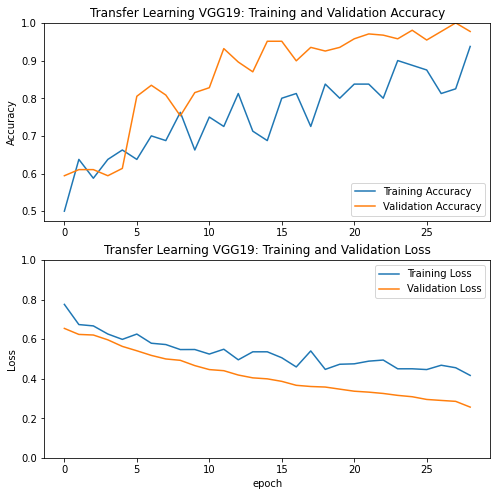

49/49 [==============================] - 3s 48ms/step - loss: 0.2728 - accuracy: 0.9584
Model accuracy on test set: 95.8%


In [ ]:
acc = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']

loss = history_final.history['loss']
val_loss = history_final.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Transfer Learning VGG19: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Transfer Learning VGG19: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

_ , accuracy = model_final.evaluate(x=X_test,y=Y_test,batch_size= batch_size,verbose=1)
print(f'Model accuracy on test set: {round(accuracy,3)*100}%')

In [ ]:
Temporary_dataset = ["/content/drive/MyDrive/Ultrasound Data/New Ultrasound Data/content/data/val/infected/img2.jpg",
                    "/content/drive/MyDrive/Ultrasound Data/New Ultrasound Data/content/data/val/infected/img6.jpg",
                     "/content/drive/MyDrive/Ultrasound Data/New Ultrasound Data/content/data/val/notinfected/img_0_100.jpg",
                     "/content/drive/MyDrive/Ultrasound Data/New Ultrasound Data/content/data/val/notinfected/img_0_1242.jpg"]

1/1 [==============================] - 0s 21ms/step


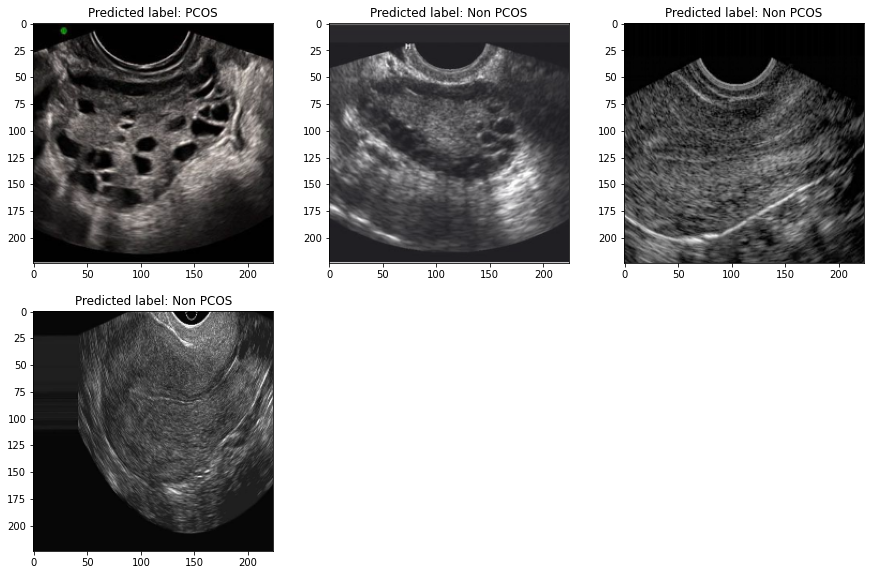

In [ ]:
IMAGE_SIZE = (224, 224)
plt.figure(figsize=(15,15))
for i in enumerate(Temporary_dataset, 1):
    plt.subplot(3,3,i[0])
    img = cv2.imread(i[1])
    img = cv2.resize(img, IMAGE_SIZE)
    plt.imshow(img)
    img = img[np.newaxis, :]
    prediction = model_final.predict(img)
    if np.argmax(prediction) == 0:
        plt.title("Predicted label: PCOS")
    else:
        plt.title("Predicted label: Non PCOS")
plt.show()

In [ ]:
model_final.save("/content/drive/MyDrive/Final_Model")

In [ ]:
from tensorflow import keras
model_try_new = keras.models.load_model('/content/drive/MyDrive/Final_Model')

1/1 [==============================] - 0s 33ms/step


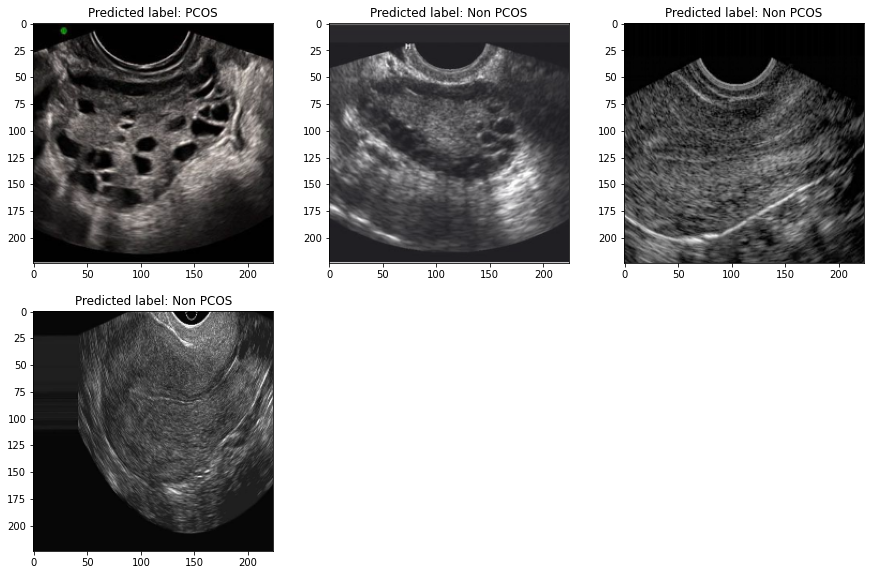

In [ ]:
IMAGE_SIZE = (224, 224)
plt.figure(figsize=(15,15))
for i in enumerate(Temporary_dataset, 1):
    plt.subplot(3,3,i[0])
    img = cv2.imread(i[1])
    img = cv2.resize(img, IMAGE_SIZE)
    plt.imshow(img)
    img = img[np.newaxis, :]
    prediction = model_try_new.predict(img)
    if np.argmax(prediction) == 0:
        plt.title("Predicted label: PCOS")
    else:
        plt.title("Predicted label: Non PCOS")
plt.show()